## Prompt-to-Prompt with Stable Diffusion

In [1]:
from typing import List
import torch
from diffusers import StableDiffusionPipeline,  DDIMScheduler
import numpy as np
import abc
import ptp_utils

In [2]:
# MY_TOKEN = '<replace with your token>'
MY_TOKEN = None
LOW_RESOURCE = False 
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77

# diffusion device
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
model_key = "runwayml/stable-diffusion-v1-5"
# model_key = "stabilityai/stable-diffusion-2-1-base"

# load diffusion model
ldm_stable = StableDiffusionPipeline.from_pretrained(model_key, local_files_only=True, torch_dtype=torch.float16).to(device)
# ldm_stable.enable_xformers_memory_efficient_attention()
tokenizer = ldm_stable.tokenizer
ldm_stable.scheduler = DDIMScheduler.from_pretrained(model_key, subfolder="scheduler",
                                                     beta_start=0.00085,beta_end=0.012,
                                                     steps_offset=1)

from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

blip_device = "cuda:1"
# blip device
processor = BlipProcessor.from_pretrained("/data/wjl/ptp_diffusion/blip/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("/data/wjl/ptp_diffusion/blip/blip-image-captioning-large").to(blip_device)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [ ]:
# code for store attention
class AttentionControl(abc.ABC):
    
    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0
    
    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn
    
    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class EmptyControl(AttentionControl):
    
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        return attn
    
    
class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 64 ** 2:  # avoid memory overhead
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention


    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}


In [ ]:
from PIL import Image

# code for aggregaring attention
def aggregate_all_attention(prompts, attention_store: AttentionStore, from_where: List[str], is_cross: bool, select: int):
    attention_maps = attention_store.get_average_attention()
    att_8 = []
    att_16 = []
    att_32 = []
    att_64 = []
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == 8*8:
                cross_maps = item.reshape(len(prompts), -1, 8, 8, item.shape[-1])[select]
                att_8.append(cross_maps)
            if item.shape[1] == 16*16:
                cross_maps = item.reshape(len(prompts), -1, 16, 16, item.shape[-1])[select]
                att_16.append(cross_maps)
            if item.shape[1] == 32*32:
                cross_maps = item.reshape(len(prompts), -1, 32, 32, item.shape[-1])[select]
                att_32.append(cross_maps)
            if item.shape[1] == 64*64:
                cross_maps = item.reshape(len(prompts), -1, 64, 64, item.shape[-1])[select]
                att_64.append(cross_maps)
    atts = []
    for att in [att_8,att_16,att_32,att_64]:
        att = torch.cat(att, dim=0)
        att = att.sum(0) / att.shape[0]
        atts.append(att.cpu())
    return atts

def aggregate_attention(prompts, attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()

# visualize cross att
def show_cross_attention(prompts,attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0):
    tokens = tokenizer.encode(prompts[select])
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(prompts, attention_store, res, from_where, True, select)
    images = []
    j = 0
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        if decoder(int(tokens[j])) == "++":
            j += 1  
        image = ptp_utils.text_under_image(image, decoder(int(tokens[j])))
        images.append(image)
        j+=1
        if j >= len(tokens):
            break
    ptp_utils.view_images(np.stack(images, axis=0))
    
# visualize self att
def show_self_attention_comp(prompts,attention_store: AttentionStore, res: int, from_where: List[str],
                        max_com=10, select: int = 0):
    attention_maps = aggregate_attention(prompts, attention_store, res, from_where, False, select).float().numpy().reshape((res ** 2, res ** 2))
    u, s, vh = np.linalg.svd(attention_maps - np.mean(attention_maps, axis=1, keepdims=True))
    images = []
    for i in range(max_com):
        image = vh[i].reshape(res, res)
        image = image - image.min()
        image = 255 * image / image.max()
        image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)
    ptp_utils.view_images(np.concatenate(images, axis=1))

In [ ]:
def run_and_display(prompts, controller, latent=None, run_baseline=False, generator=None,t=NUM_DIFFUSION_STEPS):
    images, x_t = ptp_utils.text2image_ldm_stable(ldm_stable, prompts, controller, latent=latent, num_inference_steps=t, guidance_scale=GUIDANCE_SCALE, generator=generator, low_resource=LOW_RESOURCE)
    return images, x_t

In [ ]:
# diffusion vae
vae = ldm_stable.vae.to(device)
controller = AttentionStore()

def encode_imgs(imgs):
        # imgs: [B, 3, H, W]
        imgs = 2 * imgs - 1
        posterior = vae.encode(imgs).latent_dist.mean
        latents = posterior * 0.18215
        return latents

In [ ]:
# fix random seed
def same_seeds(seed):
    torch.manual_seed(seed)  # 固定随机种子（CPU）
    if torch.cuda.is_available():  # 固定随机种子（GPU)
        torch.cuda.manual_seed(seed)  # 为当前GPU设置
        torch.cuda.manual_seed_all(seed)  # 为所有GPU设置
    np.random.seed(seed)  # 保证后续使用random函数时，产生固定的随机数
    torch.backends.cudnn.benchmark = False  # GPU、网络结构固定，可设置为True
    torch.backends.cudnn.deterministic = True  # 固定网络结构


In [ ]:
import cv2
import torch.nn.functional as F
# cam visual_code
def show_cam_on_image(img, mask):
    mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0), size=(img.size[1],img.size[0]), mode='bilinear', align_corners=False).squeeze().squeeze()
    img = np.float32(img) / 255.
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + img
    cam = cam / np.max(cam)
    cam = np.uint8(255 * cam)
    return cam

# def show_attention(mask, save_path):
#     mask = (mask-mask.min())/(mask.max()-mask.min())
#     heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
#     attention = np.uint8(heatmap)
#     cv2.imwrite(save_path, attention)

In [ ]:
# main function
def generate_att(t,input_latent,noise,prompts,controller,pos,is_self=True,is_multi_self=False,is_cross_norm=True,weight=[0.3,0.5,0.1,0.1]):
    controller.reset()
    g_cpu = torch.Generator(4307)
    latents_noisy = ldm_stable.scheduler.add_noise(input_latent, noise, torch.tensor(t,device=device))
    image, x_t = run_and_display(prompts, controller, latent=latents_noisy,run_baseline=False, generator=g_cpu,t=t)
    layers = ("mid", "up", "down")
    cross_attention_maps = aggregate_all_attention(prompts,controller, layers, True, 0)
    self_attention_maps = aggregate_all_attention(prompts,controller, ("up", "mid", "down"), False, 0)
    imgs = []
    for idx,res in enumerate([8,16,32,64]):
        out_att = cross_attention_maps[idx].permute(2,0,1).float()
        if is_cross_norm:
            att_max = torch.amax(out_att,dim=(1,2),keepdim=True)
            att_min = torch.amin(out_att,dim=(1,2),keepdim=True)
            out_att = (out_att-att_min)/(att_max-att_min)
        if is_multi_self: 
            self_att = self_attention_maps[idx].view(res*res,res*res).float() 
            self_att = self_att/self_att.max()
            out_att = torch.matmul(self_att.unsqueeze(0),out_att.view(-1,res*res,1)).view(-1,res,res)
        if res != 64:
            out_att = F.interpolate(out_att.unsqueeze(0), size=(64,64), mode='bilinear', align_corners=False).squeeze()
            
        imgs.append(out_att * weight[idx])

    cross_att_map = torch.stack(imgs).sum(0)[pos].mean(0).view(64*64, 1)

    if is_self and not is_multi_self:
        self_att = self_attention_maps[3].view(64*64,64*64).float() 
        self_att = self_att/self_att.max()
        for i in range(1):
            cross_att_map = torch.matmul(self_att,cross_att_map)
    att_map = cross_att_map.view(res,res)
    att_map = F.interpolate(att_map.unsqueeze(0).unsqueeze(0), size=(512,512), mode='bilinear', align_corners=False).squeeze().squeeze()
    att_map = (att_map-att_map.min())/(att_map.max()-att_map.min())
    att_map = F.sigmoid(8 * (att_map-0.4))
    att_map = (att_map-att_map.min())/(att_map.max()-att_map.min()) 

    att_map_map = Image.fromarray((att_map.cpu().detach().numpy()*255).astype(np.uint8),mode="L")

    display(att_map_map)
    
    print("8x8 cross att map")
    show_cross_attention(prompts,controller, res=8, from_where=layers)
    print("16x16 cross att map")
    show_cross_attention(prompts,controller, res=16, from_where=layers)
    print("32x32 cross att map")
    show_cross_attention(prompts,controller, res=32, from_where=layers)
    print("64x64 cross att map")
    show_cross_attention(prompts,controller, res=64, from_where=layers)

    # print("64x64 self att map")
    # show_self_attention_comp(prompts,controller, res=64, from_where=layers)
    
    return att_map

ori_image


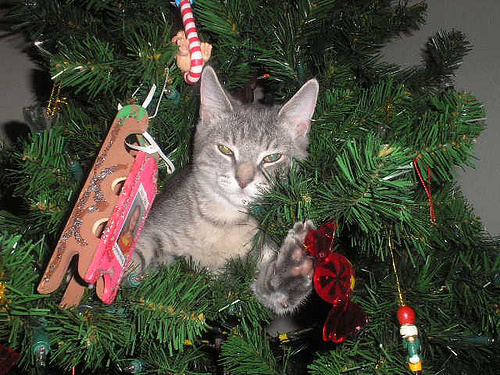

/data/wjl/.conda/envs/ldm/lib/python3.8/site-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


**** blip_prompt: a photograph of cat++ in a christmas tree with ornaments****


/data/wjl/DiffSegmenter/visual_code/ptp_utils.py:80: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = latent.expand(batch_size,  model.unet.in_channels, height // 8, width // 8).to(model.device)


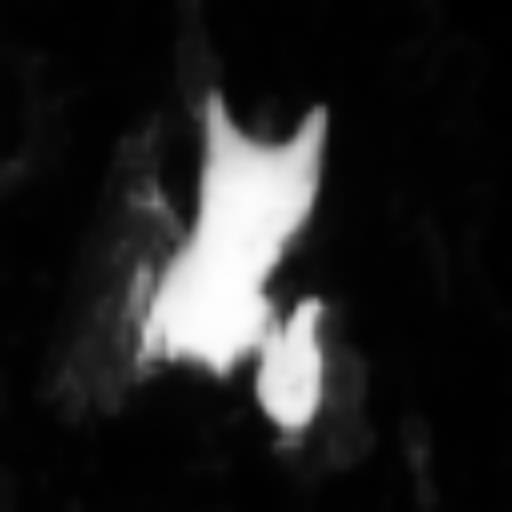

8x8 cross att map


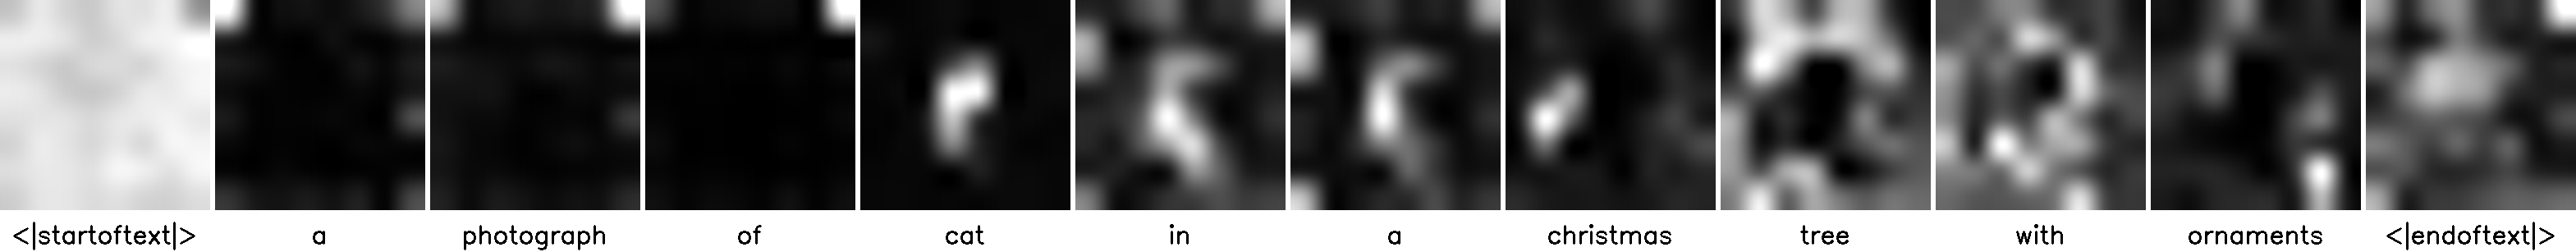

16x16 cross att map


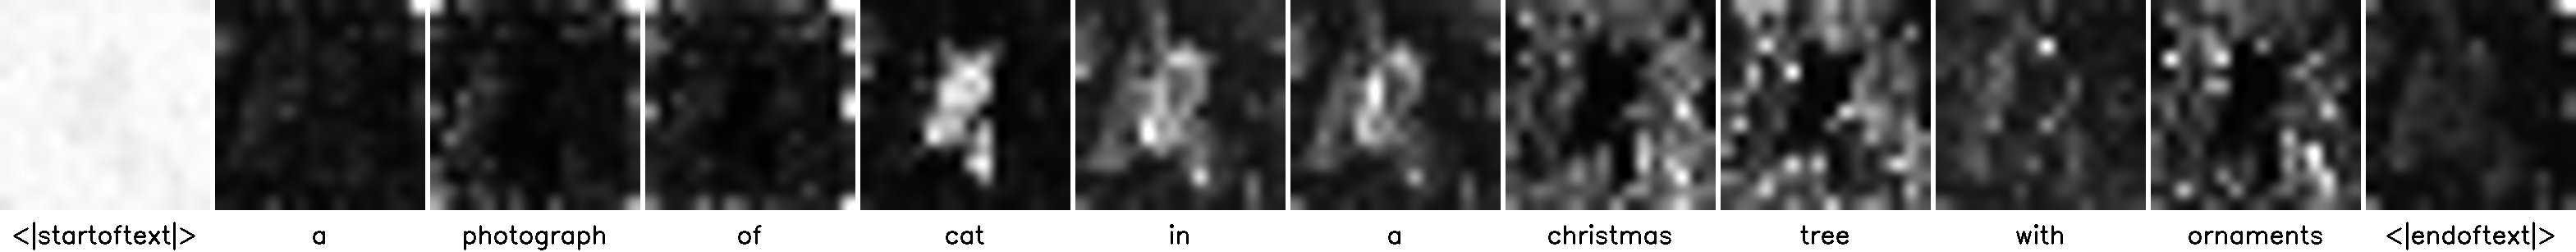

32x32 cross att map


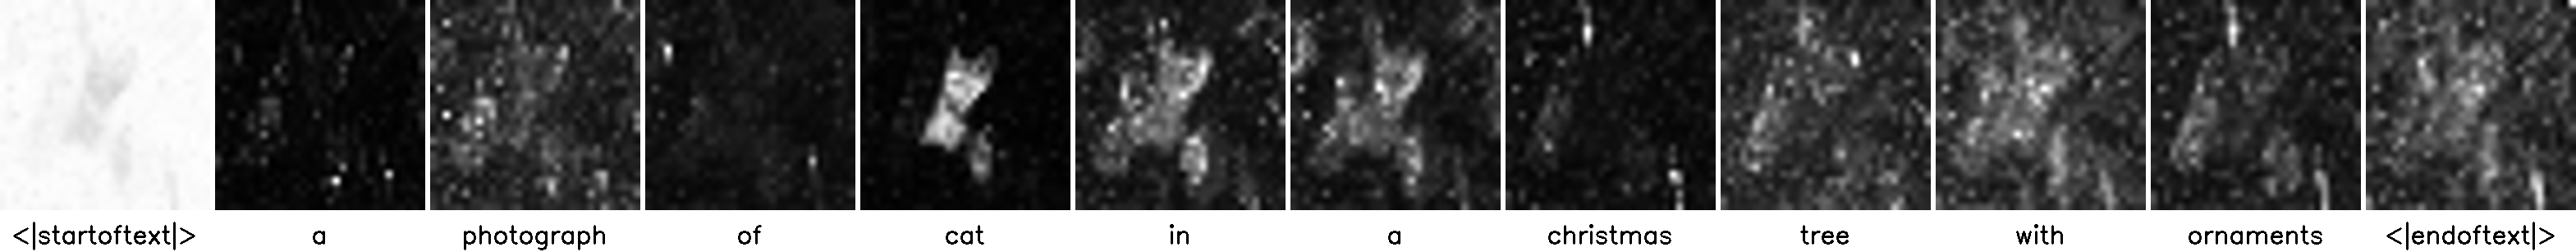

64x64 cross att map


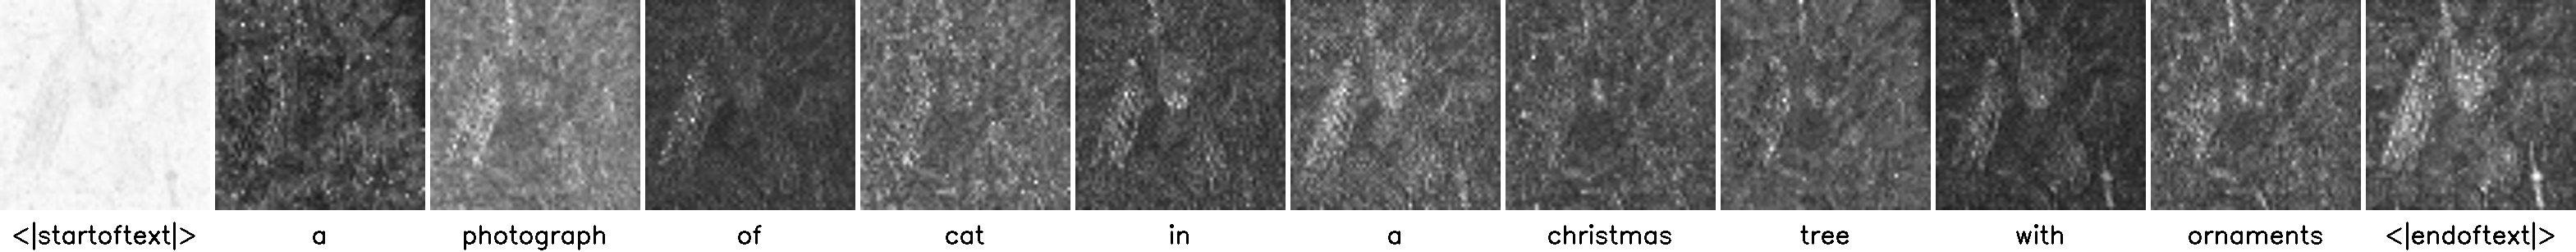

visual_cam


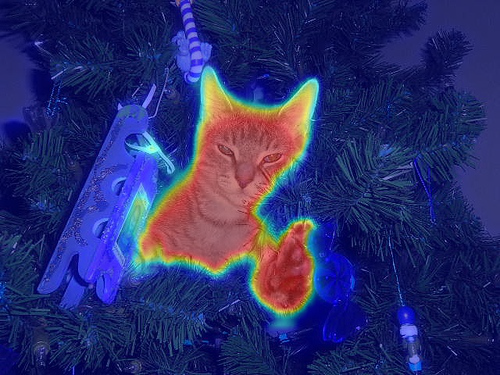

In [ ]:
from torchvision import transforms
from IPython.display import display
from PIL import Image
with torch.no_grad():
    same_seeds(3407)
    
    img_path = "./sample_img/cat.png"
    input_img = Image.open(img_path).convert("RGB")

    print("ori_image")
    display(input_img)

    t = []
    t.append(transforms.ToTensor())
    transforms = transforms.Compose(t)

    img_tensor = (transforms(input_img).unsqueeze(0)).to(device)

    rgb_512 = F.interpolate(img_tensor, (512, 512), mode='bilinear', align_corners=False).half()

    input_latent = encode_imgs(rgb_512)

    noise = torch.randn_like(input_latent).to(device)

    raw_image = input_img

    # targer class name
    cls_name = "cat"

    # sentence templete
    text = f"a photograph of {cls_name}"
    inputs = processor(raw_image,text,return_tensors="pt").to(blip_device)

    # use blip and "++" emphasizing semantic information of target categories
    out = model.generate(**inputs)
    texts = processor.decode(out[0], skip_special_tokens=True)
    texts = text +"++"+ texts[len(text):] # ", highly realistic, artsy, trending, colorful"

    g_cpu = torch.Generator(3407)
    prompts = [texts]
    print("**** blip_prompt: "+texts+"****")

    # weight is the weight of different layer's cross attn
    # pos is the position of target class word in the sentence, in "a photograph of plane" (plane)'s position is 4
    # t is the denoising step, usually set between 50 to 150
    pos = [4]   # pos of targer class word
    t = 100
    mask = generate_att(t,input_latent,noise,prompts,controller,pos,is_self=True,is_multi_self=False,is_cross_norm=True,weight=[0.3,0.5,0.1,0.1])

    cam = show_cam_on_image(raw_image,mask)
    print("visual_cam")
    display(Image.fromarray(cam[:,:,::-1]))
